# Training an Autoencoder for Image Segmentation

Organise data directories containing training data.

In [1]:
import os
import sys
import h5py  # !pip install pyyaml h5py
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2


# Database choice
batch_size = 10
num_patches = 20  # Subsample taining data
num_duplicates = 1  # Repeats of subsamples to augment
apply_augmentation = True
shuffle_on = True


# Locate data
data_file = 'tomograms2D/all'  # No leading/trailing `/`
database_name = 'all2D-pat20'
exp_name = 'ae-' + database_name


# Directories (ammend as necessary)
root_dir = '/content/gdrive/MyDrive/IDSAI/PROOF/filament-segmentation'
os.chdir(root_dir)  # Move to root_dir
sys.path.insert(0, root_dir)


# Add data to root directory and locate JSON file
data_dir = os.path.join(root_dir, 'data/' + data_file)
image_path = os.path.join(data_dir, 'png-original')
masks_path = os.path.join(data_dir, 'png-masks/semantic/*.png')


# New training and validation files
train_dir = os.path.join(root_dir, 'data/databases/' + database_name + '/train')
valid_dir = os.path.join(root_dir, 'data/databases/' + database_name + '/valid')


# Checkpoints
checkpoint_dir = os.path.join(root_dir, 'checkpoints')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_weights_path = os.path.join(checkpoint_dir, exp_name + '.h5')


# Figure Outputs
fig_dir = os.path.join(root_dir, 'outputs/ae-train-' + database_name)
os.makedirs(fig_dir, exist_ok=True)

Mounted at /content/gdrive


Choose network parameters.

In [2]:
num_epochs = 50
epoch_freq = 10
learning_rate = 0.001

Assert GPU/TPU and RAM capability.

In [3]:
%%script false
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
   print(gpu_info)

In [4]:
%%script false
# TPU initialisation for tensorflow 2.X
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [5]:
%%script false
## RAM availability
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Load data and model

In [6]:
print('\nLoading data...')
if not os.path.exists(train_dir) and not os.path.exists(valid_dir):

    from loader import augment_data, get_data
    train_imgs, train_msks, valid_imgs, valid_msks, _, _ = \
        get_data(path_train_imgs=image_path,
                 path_train_msks=masks_path,
                 path_valid_imgs='',
                 path_valid_msks='',
                 train_frac=0.8,
                 valid_frac=0.1,
                 image_size=[256, 256],
                 num_patches_per_image=num_patches,
                 num_duplicates_per_image=num_duplicates,
                 )
        
    train_set, valid_set = augment_data(train_imgs,
                                        train_msks,
                                        valid_imgs,
                                        valid_msks,
                                        batch_size,
                                        one_hot=False,
                                        augment_on=apply_augmentation,
                                        shuffle_on=True,
                                        )

    tf.data.experimental.save(train_set, train_dir)
    tf.data.experimental.save(valid_set, valid_dir)
    print('Data processed, loaded and saved.')
else:
    train_set = tf.data.experimental.load(train_dir)
    valid_set = tf.data.experimental.load(valid_dir)
    print('Data loaded from file.')
print('Training set length: ', len(train_set))
print('Validation set length: ', len(valid_set))


Loading data...


100%|██████████| 186/186 [09:51<00:00,  3.18s/it]


Data processed, loaded and saved.
Training set length:  298
Validation set length:  38


Instantiate model and load the `best-weights.h5` from previous training sessions.

In [7]:
from models import AutoEncoder, ae_train_step, ae_test_step

# Loss function
loss_fn = tf.keras.losses.MSE

# Instantiate model
model = AutoEncoder(loss_fn, lr=learning_rate)

# Call model to build and initialise weights
example_input, _ = next(iter(train_set))
model(example_input)

if os.path.exists(best_weights_path):
    model.load_weights(best_weights_path)
    print('Model loaded with previous `best weights`.')

else:
    print('Initialising model randomly.')

Initialising model randomly.


## Training Routine

Iterate training.

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  0

Saving model weights at epoch 0.

No validation loss improvement at epoch 0.
Training loss:  0.250446


Training Results.
Range of mask energies: 0.064 to 0.434


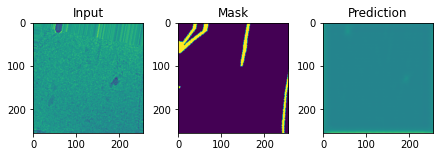



Validation Results.
Range of mask energies: 0.066 to 0.421


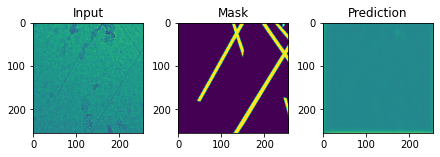



Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


In [ ]:
# Iterate training session
tlosses = []    
vlosses = []
best_epoch = 0
save_weight_improvements = False
for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    if epoch == 0:
        print('\nSaving model weights at epoch {:d}.'.format(epoch))
        if save_weight_improvements:
            model.save_weights(checkpoint_path.format(epoch=epoch),
                            save_format='h5',
                            )
        model.save_weights(best_weights_path, save_format='h5')

    # Take a training step
    for data in train_set:
        tlosses.extend(np.array(ae_train_step(data, model)).flatten())
        end_data = data

    # Compute validation loss and checkpoint every `epoch_freq` epochs
    if epoch % epoch_freq == 0:
        evls_train, _, imgs_train, msks_train = ae_test_step(end_data, model)
        accum_valid_loss = []
        for x_valid in valid_set:
            evls_valid, valid_loss, imgs_valid, msks_valid = \
                                                ae_test_step(x_valid, model)
            valid_loss = np.array(valid_loss).flatten()
            accum_valid_loss.extend(valid_loss)
        valid_loss = np.mean(accum_valid_loss)
        if epoch > 0 and all(valid_loss < past_loss for past_loss in vlosses):
            best_epoch = epoch
            print('\nValidation loss decrease from {:.3f} to {:.3f} over '
                  'epochs {:d} to {:d}.'
                  .format(vlosses[-1], valid_loss, epoch - epoch_freq, epoch)
            )
            print('Saving initial model weights at epoch {:d}.'.format(epoch))
            if save_weight_improvements:
                model.save_weights(checkpoint_path.format(epoch=epoch),
                                save_format='h5',
                                )
            model.save_weights(best_weights_path, save_format='h5')
        else:
            print('\nNo validation loss improvement at epoch {:d}.'
                  .format(epoch))
            
        vlosses.append(valid_loss)
        print('Training loss: ', tlosses[-1])

        # Graphical Output
        for i in range(min(batch_size, 1)):

            print('\n')
            print('Training Results.')
            print('Range of mask energies: {min:.3f} to {max:.3f}'
                  .format(min=np.min(evls_train[i, :, :, 0]),
                          max=np.max(evls_train[i, :, :, 0]),
                          )
                  )
            fig, ax = plt.subplots(1, 3, constrained_layout=True)
            ax[0].imshow(imgs_train[i, :, :, 0])
            ax[0].set_title('Input')
            ax[1].imshow(msks_train[i, :, :, 0])
            ax[1].set_title('Mask')
            ax[2].imshow(evls_train[i, :, :, 0])
            ax[2].set_title('Prediction')
            plt.show()
            fig.savefig(
                os.path.join(
                    fig_dir, 'train_bnum{:02d}_epoch{:04d}'.format(i, epoch),
                    )
                )

            print('\n')
            print('Validation Results.')
            print('Range of mask energies: {min:.3f} to {max:.3f}'
                  .format(min=np.min(evls_valid[i, :, :, 0]),
                          max=np.max(evls_valid[i, :, :, 0]),
                          )
                  )
            fig, ax = plt.subplots(1, 3, constrained_layout=True)
            ax[0].imshow(imgs_valid[i, :, :, 0])
            ax[0].set_title('Input')
            ax[1].imshow(msks_valid[i, :, :, 0])
            ax[1].set_title('Mask')
            ax[2].imshow(evls_valid[i, :, :, 0])
            ax[2].set_title('Prediction')
            plt.show()
            fig.savefig(
                os.path.join(fig_dir,
                             'valid_bnum{:02d}_epoch{:04d}'.format(i, epoch),
                             )
                        )
            print('\n')

In [ ]:
# Generate loss plot
fig, ax = plt.subplots(1, 1)

xt = np.linspace(
    0, num_epochs - (1/len(train_set)), num_epochs * len(train_set)
    )

xv = np.linspace(
    0, num_epochs - epoch_freq, int(num_epochs / epoch_freq)
    )

ax.plot(xt, tlosses, color='g', label='Training loss')
ax.plot(xv, vlosses, color='r', label='Validation loss')


# Best epoch
xb, yb = best_epoch, vlosses[int(best_epoch / epoch_freq)]
ax.plot(xb, yb,'bo')
ax.annotate('{}'.format(best_epoch),
            (xb, yb),
            textcoords="offset points", # how to position the text
            xytext=(0,20), # distance from text to points (x,y)
            ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.legend()
plt.show()
fig.savefig(os.path.join(fig_dir, 'loss-plot.png'))